## Importing Libraries

In [44]:
import sys, os, re, csv, codecs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
from IPython.core.display import display, HTML
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18364\3281191912.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Load Data

In [46]:
toxicWordsTrain=pd.read_csv("D:/Data Science/Machine Learning/Toxic Comments with LSTM-CNN/Toxic-Comment-with-LSTM-CNN/dataset/jigsaw-toxic-comment-classification-challenge/train.csv").fillna(' ')
toxicWordsTest=pd.read_csv("D:/Data Science/Machine Learning/Toxic Comments with LSTM-CNN/Toxic-Comment-with-LSTM-CNN/dataset/jigsaw-toxic-comment-classification-challenge/test.csv").fillna(' ')

#Class labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y_train = toxicWordsTrain[list_classes].values
x_train = toxicWordsTrain["comment_text"]
x_test  = toxicWordsTest["comment_text"]

submission = pd.read_csv("D:/Data Science/Machine Learning/Toxic Comments with LSTM-CNN/Toxic-Comment-with-LSTM-CNN/dataset/jigsaw-toxic-comment-classification-challenge/sample_submission.csv")
target = pd.read_csv("D:/Data Science/Machine Learning/Toxic Comments with LSTM-CNN/Toxic-Comment-with-LSTM-CNN/dataset/jigsaw-toxic-severity-rating/comments_to_score.csv")



# EDA

In [47]:
def overall(df):
    print ("Rows : " ,df.shape[0])
    print ("Columns : " ,df.shape[1])
    print ("\nFeatures : \n" ,df.columns.tolist())
    print ("\nMissing values : ", df.isnull().sum().values.sum())
    print ("\nUnique values : \n", df.nunique())

overall(toxicWordsTrain)

Rows :  159571
Columns :  8

Features : 
 ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Missing values :  0

Unique values : 
 id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18364\2300331020.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list_classes, y=x.values, palette=palette)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18364\2300331020.py:8: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  ax = sns.barplot(x=list_classes, y=x.values, palette=palette)


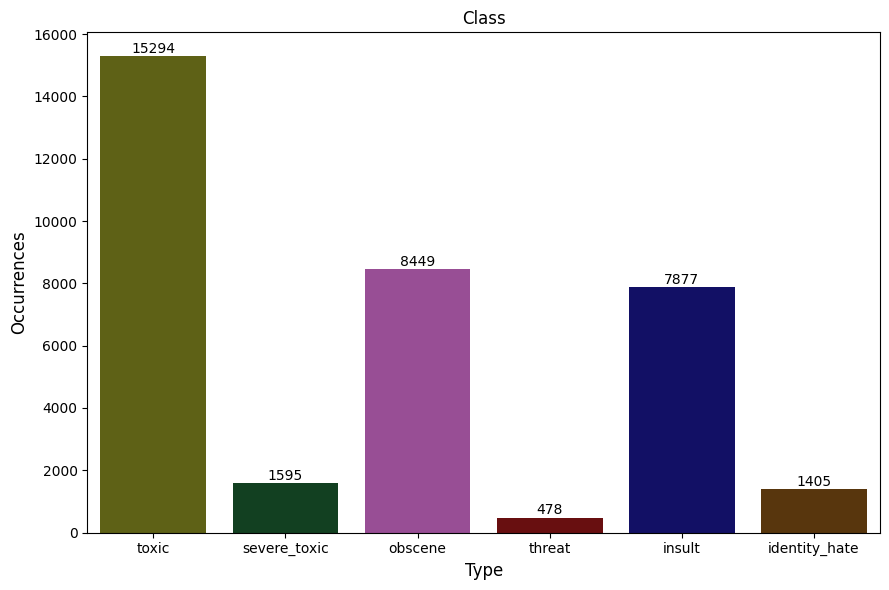

In [48]:
colors_list = ["brownish green", "pine green", "ugly purple", "blood", "deep blue", "brown", "azure"]

palette = sns.xkcd_palette(colors_list)

x = toxicWordsTrain.iloc[:, 2:].sum() 

plt.figure(figsize=(9, 6))
ax = sns.barplot(x=list_classes, y=x.values, palette=palette) 

plt.title("Class")
plt.xlabel("Type", fontsize=12)
plt.ylabel("Occurrences", fontsize=12)

rects = ax.patches
for rect, label in zip(rects, x.values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, int(label),
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [49]:
# Sample from dataset
for sample_i in range(3):
    print('Comment #{}:  {}'.format(sample_i + 1, x_train[sample_i]))
    print('Label #{}:    {}'.format(sample_i + 1, y_train[sample_i]))

Comment #1:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Label #1:    [0 0 0 0 0 0]
Comment #2:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Label #2:    [0 0 0 0 0 0]
Comment #3:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Label #3:    [0 0 0 0 0 0]


## Explore Vocabulary

In [50]:
from collections import Counter
from tqdm import tqdm


all_words = (word for sentence in tqdm(x_train, desc="Processing sentences") for word in sentence.split())
word_counter = Counter(all_words)

print('{} words.'.format(len([word for sentence in x_train for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('10 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')

Processing sentences: 100%|██████████| 159571/159571 [00:02<00:00, 76810.45it/s]


10734904 words.
532299 unique words.
10 Most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


## Preprocessing the data

We preprocess our data a bit so that it's in a format we can input into a neural network. The process includes:

1. Remove irrelevant characters (!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n).
2. Convert all letters to lowercase (HeLlO -> hello).
3. Tokenize our words (hi how are you -> [23, 1, 5, 13]).
4. Standaridize our input length with padding (hi how are you -> [23, 1, 5, 13, 0, 0, 0]).

In [51]:
# Create tokenizer
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ", char_level=False)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(x_train))
tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index

In [52]:
# Extract variables
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))

longest = max(len(seq) for seq in tokenized_train)
print("Longest comment size: {}".format(longest))

average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))

stdev = np.std([len(seq) for seq in tokenized_train])
print("Stdev of comment size: {}".format(stdev))

max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))


Vocab size: 210337
Longest comment size: 1403
Average comment size: 68.22156908210138
Stdev of comment size: 101.07344657013672
Max comment size: 371


In [53]:
# Pad sequences
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

In [54]:
# Sample tokenization
for sample_i, (sent, token_sent) in enumerate(zip(x_train[:3], tokenized_train[:3])):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

Sequence 1
  Input:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
  Output: [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]
Sequence 2
  Input:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
  Output: [96145, 52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]
Sequence 3
  Input:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than 

After preprocessing, our vocabulary size drops to a more manageable 210,337 with a max comment size of 371 words and an average comment size of about 68 words per sentence